<a href="https://colab.research.google.com/github/alvaro-barrera/phishing-detection-url/blob/main/project_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [208]:
#CONEXIÓN A DRIVE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [209]:
#INGRESANDO A CARPETA CONTENEDORA DE ARCHIVOS EN DRIVE "ml_database"
%cd '/content/drive/My Drive/Colab Notebooks/db'

/content/drive/My Drive/Colab Notebooks/db


#	Importación de librerías 

In [210]:
#IMPORTACIÓN DE LIBRERÍAS
import pandas as pd #IMPORTACIÓN DE LIBRERIA - PANDAS
import numpy as np #IMPORTACIÓN DE LIBRERIA - NUMPY
import seaborn as sn #IMPORTACIÓN DE LIBRERIA - SEABORN
import matplotlib.pyplot as plt #IMPORTACIÓN DE LIBRERIA - MATPLOT
%matplotlib inline
#IMPORTACIÓN DE LIBRERÍA SKLEARN
from sklearn.model_selection import train_test_split  #DIVIDIR LOS DATOS DE ENTRENAMIENTO Y TEST
from sklearn.model_selection import KFold #DIVIDE UN CONJUNTO DE DATOS EN K BLOQUES - VALIDACIÓN Y ENTRENAMIENTO
from sklearn.model_selection import cross_val_score #EVALUAR NUESTRO MODELO USANDO EL ESQUEMA DE VALIDACIÓN CRUZADA
from sklearn.preprocessing import MinMaxScaler #POR DEFECTO USA VALORES ENTRE 0-1
from sklearn.preprocessing import StandardScaler 

#IMPORTACIÓN DE MODELOS SKLEARN PARA REALIZAR CLASFICACIONES
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier

#TRATAMIENTO DE URL's
from urllib.parse import urlparse
#TRATAMIENTO DE ARCHIVOS
from google.colab import files #DESCARGAR ARCHIVOS
from datetime import datetime #MANIPULAR FECHAS DATATIME
from sklearn.pipeline import Pipeline #AUTOMARIZAR FLUJO DE TRABAJO
import joblib #GUARDAR FLUJO DE TRABAJO

#IGNORAR ALERTAS
import warnings
warnings.filterwarnings('ignore')

# Conjuntos de datos para la detección de sitios web de phishing


## Breve descripción del conjunto de datos:

> Número total de instancias: 88,647

> Número de instancias de sitios web legítimos (etiquetadas como 0): 58,000

> Número de instancias de sitios web de phishing (etiquetadas como 1): 30,647

In [211]:
#CARGA DE ARCHIVO .CSV 
dataset_complete = pd.read_csv('dataset_small.csv',
                      sep=',', #DEFINIENDO SEPARADOR ',' PROPIO DE .CSV
                      encoding='utf-8', #CODIFICACIÓN UTF-8
                      na_values=' ')

## Resumen estadístico para el dataset original

In [212]:
dataset_complete.describe()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,qty_tilde_url,qty_comma_url,qty_plus_url,qty_asterisk_url,qty_hashtag_url,qty_dollar_url,qty_percent_url,qty_tld_url,length_url,qty_dot_domain,qty_hyphen_domain,qty_underline_domain,qty_slash_domain,qty_questionmark_domain,qty_equal_domain,qty_at_domain,qty_and_domain,qty_exclamation_domain,qty_space_domain,qty_tilde_domain,qty_comma_domain,qty_plus_domain,qty_asterisk_domain,qty_hashtag_domain,qty_dollar_domain,qty_percent_domain,qty_vowels_domain,domain_length,domain_in_ip,server_client_domain,...,qty_hashtag_file,qty_dollar_file,qty_percent_file,file_length,qty_dot_params,qty_hyphen_params,qty_underline_params,qty_slash_params,qty_questionmark_params,qty_equal_params,qty_at_params,qty_and_params,qty_exclamation_params,qty_space_params,qty_tilde_params,qty_comma_params,qty_plus_params,qty_asterisk_params,qty_hashtag_params,qty_dollar_params,qty_percent_params,params_length,tld_present_params,qty_params,email_in_url,time_response,domain_spf,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
count,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.0,58645.0,58645.0,58645.000000,58645.0,58645.0,58645.0,58645.0,58645.0,58645.0,58645.0,58645.0,58645.0,58645.0,58645.000000,58645.000000,58645.000000,58645.000000,...,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,2.284338,0.457123,0.171285,1.937522,0.014102,0.311177,0.033456,0.212959,0.004451,0.001535,0.004877,0.003274,0.004212,0.006855,0.000767,0.002865,0.162503,1.068429,44.959297,1.799540,0.133294,0.000290,0.0,0.0,0.0,0.000017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.440992,18.073016,0.003427,0.003530,...,-0.298525,-0.298525,-0.242305,4.659067,-0.714451,-0.816506,-0.791781,-0.830898,-0.860670,-0.587723,-0.846193,-0.680791,-0.872692,-0.873323,-0.873357,-0.871242,-0.870969,-0.873305,-0.873442,-0.872862,-0.791559,8.482462,-0.836354,-0.636832,0.027709,0.776379,-0.030147,33140.826447,2531.939483,293.615074,1.110666,2.829619,1.630113,5056.676272,0.501373,0.303419,0.001279,0.002234,0.008287,0.522585
std,1.473209,1.339340,0.801919,2.037525,0.138156,1.159198,0.343272,1.130323,0.107352,0.089320,0.096013,0.093381,0.136331,0.370849,0.075802,0.122604,2.115804,0.305755,54.712657,0.790989,0.465673,0.019802,0.0,0.0,0.0,0.004129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.714293,7.244541,0.058444,0.059307,...,0.457615,0.457615,1.713954,16.358671,1.193137,0.771199,0.797698,0.663899,0.386856,1.345035,0.432952,1.235146,0.339404,0.333280,0.332832,0.347086,0.347966,0.333350,0.332480,0.336390,1.285886,42.598270,0.459396,1.137735,0.164139,1.572495,0.591021,50339.910407,2799.792419,562.400108,0.912962,1.377018,1.719554,7102.853538,0.500002,0.815315,0.037599,0.047927,0.090657,0.499494
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,4.000000,0.000000,0.000000,...,-1.000000,-1.00000

## Matriz de correlación al dataset original

In [261]:
dataset_complete.columns

Index(['qty_dot_url', 'qty_hyphen_url', 'qty_underline_url', 'qty_slash_url',
       'qty_questionmark_url', 'qty_equal_url', 'qty_at_url', 'qty_and_url',
       'qty_exclamation_url', 'qty_space_url',
       ...
       'qty_ip_resolved', 'qty_nameservers', 'qty_mx_servers', 'ttl_hostname',
       'tls_ssl_certificate', 'qty_redirects', 'url_google_index',
       'domain_google_index', 'url_shortened', 'phishing'],
      dtype='object', length=112)

In [213]:
dataset_corr_matrix = dataset_complete.corr(method='pearson') # Matriz de correlación
dataset_corr_matrix

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,qty_tilde_url,qty_comma_url,qty_plus_url,qty_asterisk_url,qty_hashtag_url,qty_dollar_url,qty_percent_url,qty_tld_url,length_url,qty_dot_domain,qty_hyphen_domain,qty_underline_domain,qty_slash_domain,qty_questionmark_domain,qty_equal_domain,qty_at_domain,qty_and_domain,qty_exclamation_domain,qty_space_domain,qty_tilde_domain,qty_comma_domain,qty_plus_domain,qty_asterisk_domain,qty_hashtag_domain,qty_dollar_domain,qty_percent_domain,qty_vowels_domain,domain_length,domain_in_ip,server_client_domain,...,qty_hashtag_file,qty_dollar_file,qty_percent_file,file_length,qty_dot_params,qty_hyphen_params,qty_underline_params,qty_slash_params,qty_questionmark_params,qty_equal_params,qty_at_params,qty_and_params,qty_exclamation_params,qty_space_params,qty_tilde_params,qty_comma_params,qty_plus_params,qty_asterisk_params,qty_hashtag_params,qty_dollar_params,qty_percent_params,params_length,tld_present_params,qty_params,email_in_url,time_response,domain_spf,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
qty_dot_url,1.000000,0.097781,0.119611,0.230117,0.416628,0.503372,0.168633,0.559617,0.001702,-0.001502,0.025278,0.040335,0.019168,-0.003099,0.000947,0.010218,0.054215,0.412330,0.454406,0.461456,0.035055,0.001851,NaN,NaN,NaN,0.002006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.152756,0.280986,0.058988,0.019740,...,0.119991,0.119991,0.028961,0.099552,0.724009,0.236077,0.240869,0.301098,0.452800,0.492980,0.410917,0.581193,0.358565,0.360588,0.361545,0.355627,0.351349,0.360745,0.361316,0.361945,0.174251,0.399878,0.422435,0.415295,0.335803,0.011160,-0.006057,0.004815,-0.024738,-0.058713,-0.049259,-0.030655,-0.045841,0.051002,-0.066587,-0.049028,-0.006565,-0.004649,-0.066927,0.140542
qty_hyphen_url,0.097781,1.000000,0.201111,0.266752,0.053262,0.156433,0.033867,0.114237,0.014788,0.016942,0.003615,0.024982,0.008320,0.000866,0.002927,0.011963,0.025620,0.119656,0.381573,-0.003478,0.358532,-0.004996,NaN,NaN,NaN,-0.001409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.101359,0.136928,-0.013263,0.040439,...,0.173437,0.173437,0.044456,0.262384,0.092676,0.450560,0.210792,0.147121,0.142662,0.160213,0.132381,0.135751,0.144500,0.145013,0.144172,0.142555,0.139841,0.144659,0.143799,0.146687,0.080091,0.219355,0.143558,0.175310,0.056637,-0.003784,0.005196,-0.006949,-0.055222,0.003269,0.049440,0.029647,-0.009515,-0.021906,0.019281,0.015099,-0.002805,0.011985,-0.019403,0.140790
qty_underline_url,0.119611,0.201111,1.000000,0.216192,0.060388,0.322340,0.050482,0.246420,0.059878,-0.002003,0.037431,0.028035,0.025376,0.013827,0.006814,0.016515,0.082096,0.131834,0.411901,-0.023452,0.042241,0.026941,NaN,NaN,NaN,0.004267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027398,0.019864,-0.000520,0.019198,...,0.139294,0.139294,0.077726,0.234849,0.154172,0.357916,0.737951,0.245034,0.270073,0.340464,0.259912,0.295071,0.304183,0.293333,0.294005,0.286512,0.288980,0.293707,0.293731,0.294058,0.152966,0.351379,0.263428,0.371964,0.072374,-0.002229,0.014997,0.017646,-0.054773,-0.031016,0.011840,0.017982,0.003877,-0.020146,0.019040,-0.005499,-0.002741,0.004686,-0.018822,0.150771
qty_slash_url,0.230117,0.266752,0.216192,1.000000,0.176379,0.245621,0.085710,0.172184,0.016317,0.011677,0.065799,0.074028,0.018504,0.002011,0.000310,0.018328,0.025241,0.237906,0.525964,-0.169758,0.018015,-0.003777,NaN,NaN,NaN,-0.001900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.081001,0.021697,0.029435,0.017630,...,0.620343,0.620343,0.168172,0.191786,0.238950,0.205604,0.218274,0.353122,0.311791,0.255161,0.293712,0.216549,0.298150,0.299779,0.300355,0.302217,0.290365,0.299918,0.300489,0.300905,0.100240,0.216704,0.305225,0.255767,0.166959,0.051315,0.019690,0.030390,-0.156589,-0.038269,-0.036443,-0.083265,-0.001904,0.097945,-0

## Matriz de correlación en formato tidy

Conjuntos de datos 'tidy' están ordenados de tal manera que cada variable es una columna y cada observación (o caso) es una fila.

In [214]:
#TRANSFORMACIÓN DE LA MATRIZ DE CORRELACIÓN A FORMATO TIDY
def tidy_correlation_matrix(correlation_matrix):
  correlation_matrix = correlation_matrix.stack().reset_index()
  correlation_matrix.columns = ['var_1','var_2','r']
  correlation_matrix = correlation_matrix.loc[correlation_matrix['var_1'] != correlation_matrix['var_2'], :]
  correlation_matrix['abs_r'] = np.abs(correlation_matrix['r'])
  correlation_matrix = correlation_matrix.sort_values('abs_r', ascending=False) #ORDENANDO LA CORRELACIÓN DESCENDENTE
  return correlation_matrix

matrix = tidy_correlation_matrix(dataset_corr_matrix)

In [306]:
#SELECCIÓN DE VARIABLES - CORRELACIÓN MAYOR A 0.5
matrix_target_order = matrix[matrix['var_1'] == 'phishing'].sort_values('abs_r',ascending=False)
# matrix_target_order
data_sign =matrix_target_order[matrix_target_order['r'] >= 0.29]
# data_sign
sign_columns = data_sign['var_2'].values.tolist()
sign_columns.append('phishing')
dataset = dataset_complete[dataset_complete.columns[dataset_complete.columns.isin(sign_columns)]]

In [307]:
#TOTAL DE VARIABLES EN DATASET
dataset.columns.size

41

In [308]:
dataset.columns

Index(['qty_slash_url', 'length_url', 'qty_dot_directory',
       'qty_hyphen_directory', 'qty_underline_directory',
       'qty_slash_directory', 'qty_questionmark_directory',
       'qty_equal_directory', 'qty_at_directory', 'qty_and_directory',
       'qty_exclamation_directory', 'qty_space_directory',
       'qty_tilde_directory', 'qty_comma_directory', 'qty_plus_directory',
       'qty_asterisk_directory', 'qty_hashtag_directory',
       'qty_dollar_directory', 'directory_length', 'qty_dot_file',
       'qty_hyphen_file', 'qty_underline_file', 'qty_slash_file',
       'qty_questionmark_file', 'qty_equal_file', 'qty_at_file',
       'qty_and_file', 'qty_exclamation_file', 'qty_space_file',
       'qty_tilde_file', 'qty_comma_file', 'qty_plus_file',
       'qty_asterisk_file', 'qty_hashtag_file', 'qty_dollar_file',
       'qty_space_params', 'qty_tilde_params', 'qty_asterisk_params',
       'qty_hashtag_params', 'qty_dollar_params', 'phishing'],
      dtype='object')

In [309]:
dataset[dataset['length_url'] == -1]

,qty_slash_url,length_url,qty_dot_directory,qty_hyphen_directory,qty_underline_directory,qty_slash_directory,qty_questionmark_directory,qty_equal_directory,qty_at_directory,qty_and_directory,qty_exclamation_directory,qty_space_directory,qty_tilde_directory,qty_comma_directory,qty_plus_directory,qty_asterisk_directory,qty_hashtag_directory,qty_dollar_directory,directory_length,qty_dot_file,qty_hyphen_file,qty_underline_file,qty_slash_file,qty_questionmark_file,qty_equal_file,qty_at_file,qty_and_file,qty_exclamation_file,qty_space_file,qty_tilde_file,qty_comma_file,qty_plus_file,qty_asterisk_file,qty_hashtag_file,qty_dollar_file,qty_space_params,qty_tilde_params,qty_asterisk_params,qty_hashtag_params,qty_dollar_params,phishing


## Distribución de clases

*   Sitio web legítimo (Clase 0): 50,000 registros
*   Sitio web de phishing (Clase 1): 30,647 registros

In [311]:
dataset.groupby('phishing').size()

phishing
0    27998
1    30647
dtype: int64

# Histogramas para dataset

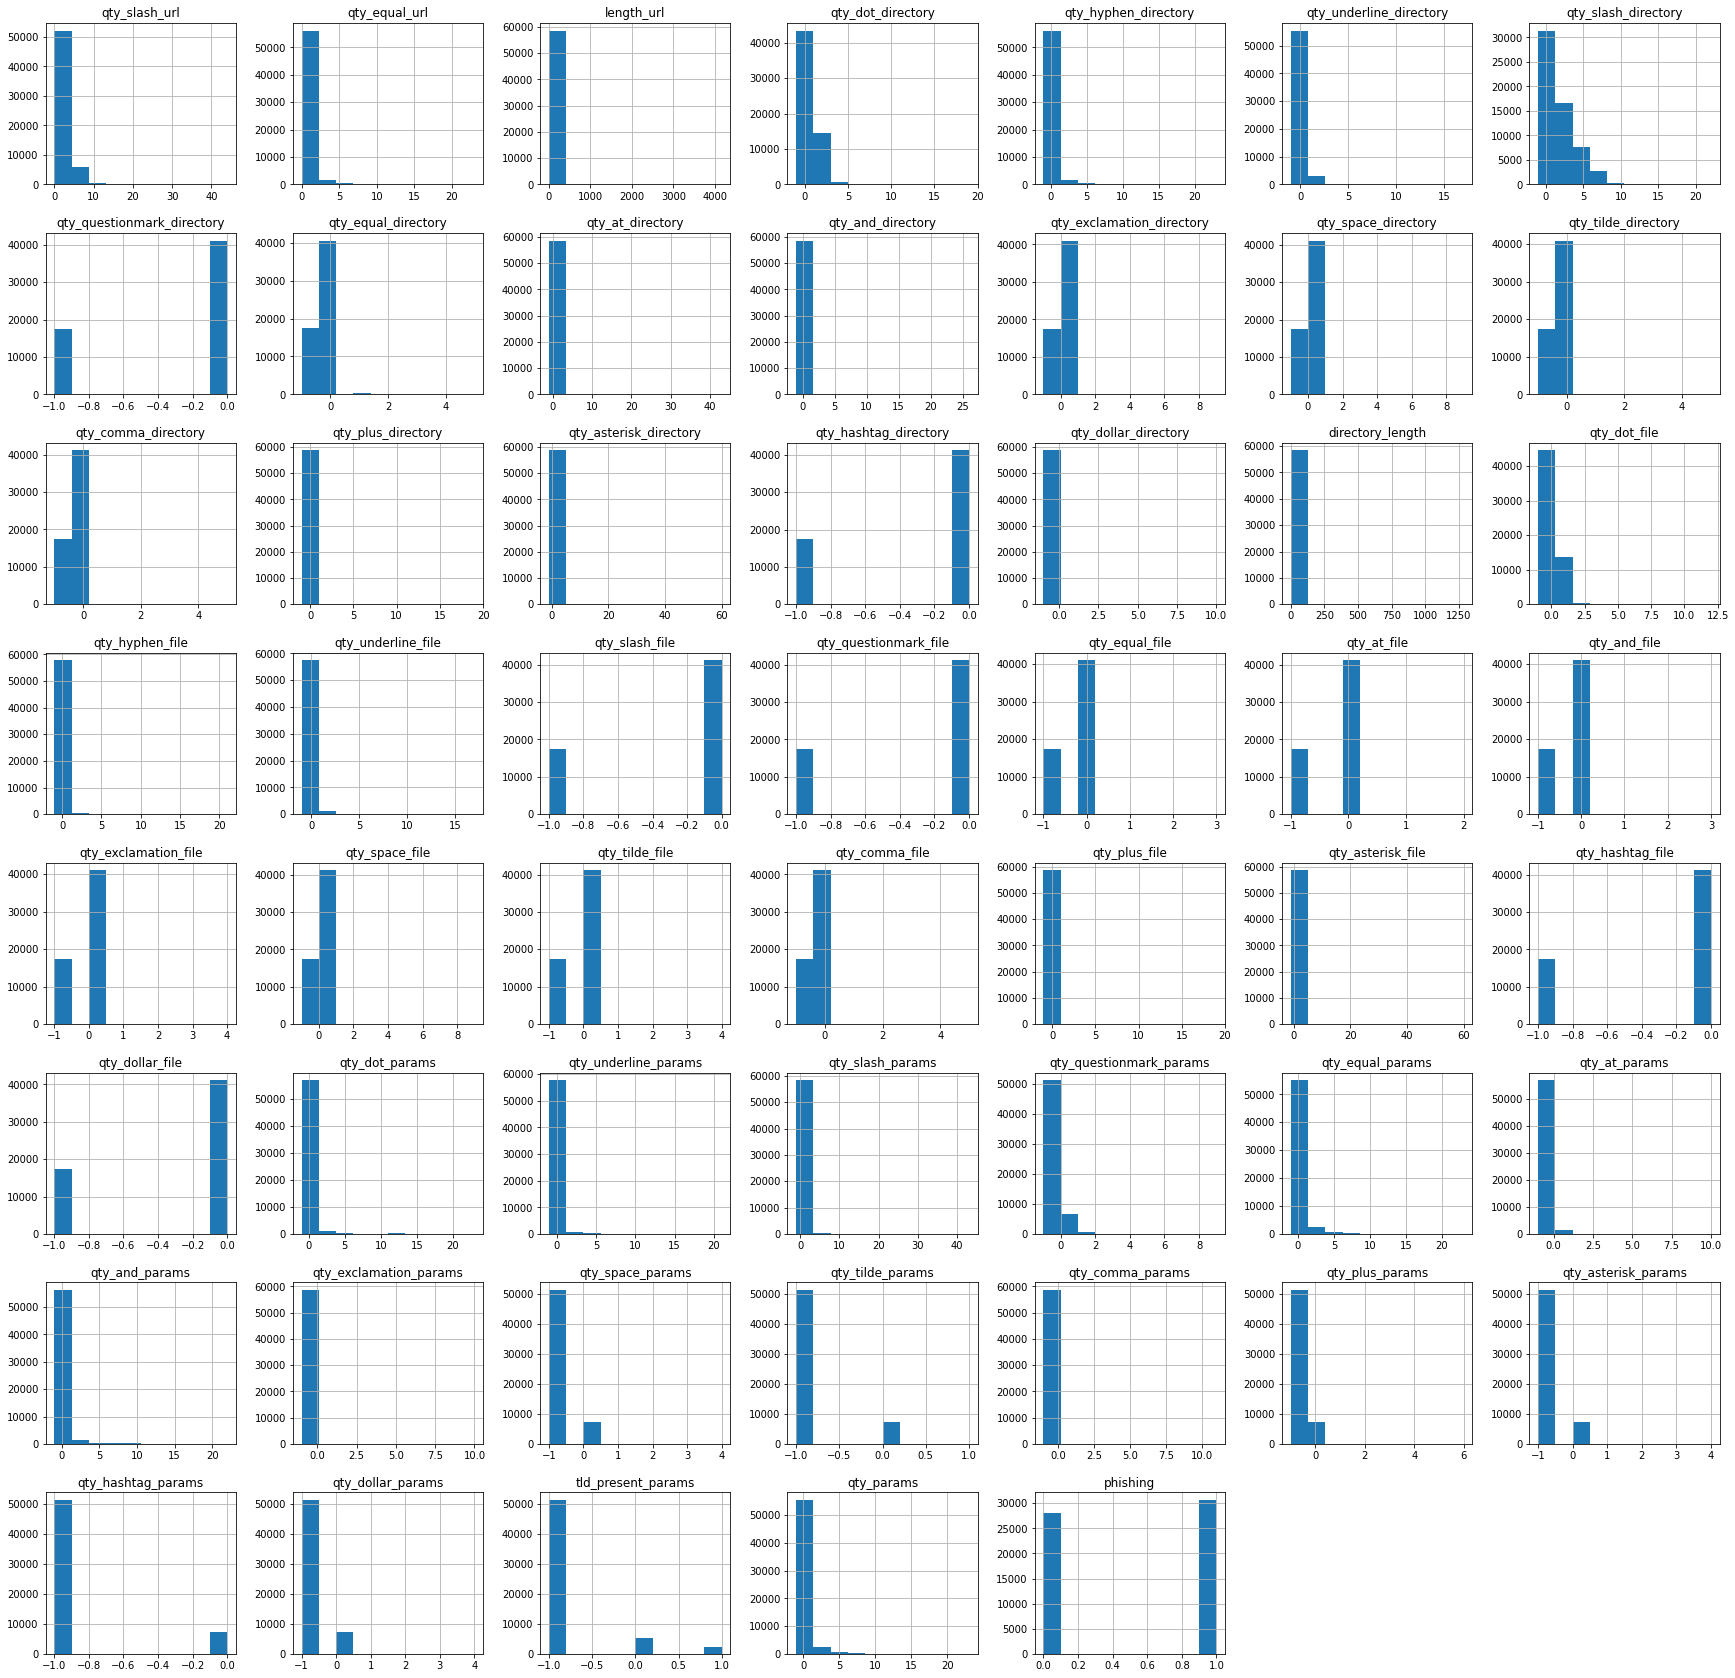

In [268]:
fig = plt.figure(figsize=(30,30))
ax = fig.gca()
dataset.hist(ax=ax)
plt.show()

# Visualización de datos estadísticos

Variable objetivo: "phishing"

## Descripción de los atributos del dataset

|          Feature           |                   Description                      |
|----------------------------|----------------------------------------------------|
| qty_dot_url                | contador de (.) en URL                                   |
| qty_hyphen_url             | contador de (-) en URL                                   |
| qty_underline_url          | contador de (_) en URL                                   |
| qty_slash_url              | contador de (/) en URL                                   |
| qty_questionmark_url       | contador de (?) en URL                                   |
| qty_equal_url              | contador de (=) en URL                                   |
| qty_at_url                 | contador de (@) en URL                                   |
| qty_and_url                | contador de (&) en URL                                   |
| qty_exclamation_url        | contador de (!) en URL                                   |
| qty_space_url	             | contador de ( ) en URL                                   |
| qty_tilde_url	             | contador de (~) en URL                                   |
| qty_comma_url	             | contador de (,) en URL                                   |
| qty_plus_url	             | contador de (+) en URL                                   |
| qty_asterisk_url	         | contador de (*) en URL                                   |
| qty_hashtag_url	         | contador de (#) en URL                                   |
| qty_dollar_url	         | contador de (símbolo de dólar) en URL                                   |
| qty_percent_url	         | contador de (%) en URL                                   |
| qty_tld_url	             | top-level-domain length                            |
| length_url	             | URL length                                         |
| qty_dot_domain	         | contador de (.) en el dominio                                |
| qty_hyphen_domain	         | contador de (-) en el dominio                                |
| qty_underline_domain       | contador de (_) en el dominio                                |
| qty_slash_domain	         | contador de (/) en el dominio                                |
| qty_questionmark_domain    | contador de (?) en el dominio                                |
| qty_equal_domain           | contador de (=) en el dominio                                |
| qty_at_domain              | contador de (@) en el dominio                                |
| qty_and_domain             | contador de (&) en el dominio                                |
| qty_exclamation_domain     | contador de (!) en el dominio                                |
| qty_space_domain           | contador de ( ) en el dominio                                |
| qty_tilde_domain           | contador de (~) en el dominio                                |
| qty_comma_domain           | contador de (,) en el dominio                                |
| qty_plus_domain            | contador de (+) en el dominio                                |
| qty_asterisk_domain        | contador de (*) en el dominio                                |
| qty_hashtag_domain         | contador de (#) en el dominio                                |
| qty_dollar_domain          | contador de (símbolo de dólar) en el dominio                                |
| qty_percent_domain         | contador de (%) en el dominio                                |
| qty_vowels_domain          | count vowels en el dominio                             |
| domain_length              | domain length                                      |
| domain_in_ip               | Dominio de URL en formato de dirección IP                    |
| server_client_domain       | el dominio contiene las palabras clave "server" o "client"  |
| qty_dot_directory	         | contador de (.) en directorio                             |
| qty_hyphen_directory       | contador de (-) en directorio                             |
| qty_underline_directory    | contador de (_) en directorio                             |
| qty_slash_directory        | contador de (/) en directorio                             |
| qty_questionmark_directory | contador de (?) en directorio                             |
| qty_equal_directory        | contador de (=) en directorio                             |
| qty_at_directory           | contador de (@) en directorio                             |
| qty_and_directory          | contador de (&) en directorio                             |
| qty_exclamation_directory	 | contador de (!) en directorio                             |
| qty_space_directory        | contador de ( ) en directorio                             |
| qty_tilde_directory        | contador de (~) en directorio                             |
| qty_comma_directory        | contador de (,) en directorio                             |
| qty_plus_directory         | contador de (+) en directorio                             |
| qty_asterisk_directory     | contador de (*) en directorio                             |
| qty_hashtag_directory      | contador de (#) en directorio                             |
| qty_dollar_directory       | contador de (símbolo de dólar) en directorio                             |
| qty_percent_directory      | contador de (%) en directorio                             |
| directory_length           | directory length                                   |
| qty_dot_file               | contador de (.) en archivo                                  |
| qty_hyphen_file            | contador de (-) en archivo                                  |
| qty_underline_file         | contador de (_) en archivo                                  |
| qty_slash_file             | contador de (/) en archivo                                  |
| qty_questionmark_file      | contador de (?) en archivo                                  |
| qty_equal_file             | contador de (=) en archivo                                  |
| qty_at_file                | contador de (@) en archivo                                  |
| qty_and_file               | contador de (&) en archivo                                  |
| qty_exclamation_file       | contador de (!) en archivo                                  |
| qty_space_file             | contador de ( ) en archivo                                  |
| qty_tilde_file             | contador de (~) en archivo                                  |
| qty_comma_file             | contador de (,) en archivo                                  |
| qty_plus_file	             | contador de (+) en archivo                                  |
| qty_asterisk_file          | contador de (*) en archivo                                  |
| qty_hashtag_file           | contador de (#) en archivo                                  |
| qty_dollar_file            | contador de (símbolo de dólar) en archivo                                  |
| qty_percent_file           | contador de (%) en archivo                                  |
| file_length                | longitud de archivo                                        |
| qty_dot_params             | contador de (.) en parámetros                            |
| qty_hyphen_params          | contador de (-) en parámetros                            |
| qty_underline_params       | contador de (_) en parámetros                            |
| qty_slash_params           | contador de (/) en parámetros                            |
| qty_questionmark_params    | contador de (?) en parámetros                            |
| qty_equal_params           | contador de (=) en parámetros                            |
| qty_at_params              | contador de (@) en parámetros                            |
| qty_and_params             | contador de (&) en parámetros                            |
| qty_exclamation_params     | contador de (!) en parámetros                            |
| qty_space_params           | contador de ( ) en parámetros                            |
| qty_tilde_params           | contador de (~) en parámetros                            |
| qty_comma_params           | contador de (,) en parámetros                            |
| qty_plus_params            | contador de (+) en parámetros                            |
| qty_asterisk_params        | contador de (*) en parámetros                            |
| qty_hashtag_params         | contador de (#) en parámetros                            |
| qty_dollar_params          | contador de (símbolo de dólar) en parámetros                            |
| qty_percent_params         | contador de (%) en parámetros                            |
| params_length              | longitud de parametros                                  |
| tld_present_params         | presencia de TLD dentro de los argumentos                          |
| qty_params                 | número de parametros                               |
| email_in_url               | email presente en URL                               |
| time_response              | tiempo de busqueda (respuesta) domain (lookup)             |
| domain_spf                 | domonio posee SPF                                     |
| asn_ip                     | Numero AS (o ASN)                                 |
| time_domain_activation     | tiempo (en días) de activacion de dominio                |
| time_domain_expiration     | tiempo (en días) de expiracion de dominio                |
| qty_ip_resolved            | IPs resueltas                            |
| qty_nameservers            | number of resolved name servers (NameServers - NS) |
| qty_mx_servers             | Servidores MX                               |
| ttl_hostname               | time-to-live (TTL) associado con el hostname  |
| tls_ssl_certificate        | Certificado TLS / SSL valido                        |
| qty_redirects              | numero de redirecciones                               |
| url_google_index           | checkeo si URL está indexada en Google                  |
| domain_google_index        | checkeo si dominio está indexado en Google               |
| url_shortened              | checkeo si URL está acortado                          |
                            |

In [269]:
#VISUALIZACIÓN DE DATOS ESTADÍSTICOS DEL DATAFRAME
dataset.describe()

,qty_slash_url,qty_equal_url,length_url,qty_dot_directory,qty_hyphen_directory,qty_underline_directory,qty_slash_directory,qty_questionmark_directory,qty_equal_directory,qty_at_directory,qty_and_directory,qty_exclamation_directory,qty_space_directory,qty_tilde_directory,qty_comma_directory,qty_plus_directory,qty_asterisk_directory,qty_hashtag_directory,qty_dollar_directory,directory_length,qty_dot_file,qty_hyphen_file,qty_underline_file,qty_slash_file,qty_questionmark_file,qty_equal_file,qty_at_file,qty_and_file,qty_exclamation_file,qty_space_file,qty_tilde_file,qty_comma_file,qty_plus_file,qty_asterisk_file,qty_hashtag_file,qty_dollar_file,qty_dot_params,qty_underline_params,qty_slash_params,qty_questionmark_params,qty_equal_params,qty_at_params,qty_and_params,qty_exclamation_params,qty_space_params,qty_tilde_params,qty_comma_params,qty_plus_params,qty_asterisk_params,qty_hashtag_params,qty_dollar_params,tld_present_params,qty_params,phishing
count,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,1.937522,0.311177,44.959297,0.022338,-0.033814,-0.210947,1.590383,-0.298525,-0.287049,-0.293409,-0.291704,-0.296070,-0.297331,-0.293733,-0.297451,-0.296905,-0.292932,-0.298525,-0.296547,16.923932,-0.045750,-0.211084,-0.260466,-0.298525,-0.298525,-0.296035,-0.298082,-0.296377,-0.296956,-0.297877,-0.298082,-0.297672,-0.297366,-0.296752,-0.298525,-0.298525,-0.714451,-0.791781,-0.830898,-0.860670,-0.587723,-0.846193,-0.680791,-0.872692,-0.873323,-0.873357,-0.871242,-0.870969,-0.873305,-0.873442,-0.872862,-0.836354,-0.636832,0.522585
std,2.037525,1.159198,54.712657,0.932358,1.231963,0.702284,2.269983,0.457615,0.483261,0.539680,0.517823,0.465111,0.465625,0.470538,0.461188,0.471482,0.580336,0.457615,0.472520,28.066352,0.762056,0.870709,0.606537,0.457615,0.457615,0.463333,0.458425,0.461529,0.460601,0.461782,0.458945,0.460731,0.468779,0.531246,0.457615,0.457615,1.193137,0.797698,0.663899,0.386856,1.345035,0.432952,1.235146,0.339404,0.333280,0.332832,0.347086,0.347966,0.333350,0.332480,0.336390,0.459396,1.137735,0.499494
min,0.000000,0.000000,4.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,0.000000,0.000000,18.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,1.000000,0.000000,29.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,

Verificamos la cantidad de datos nulos por columna

In [270]:
#Conteo de valores
dataset.count() 

qty_slash_url                 58645
qty_equal_url                 58645
length_url                    58645
qty_dot_directory             58645
qty_hyphen_directory          58645
qty_underline_directory       58645
qty_slash_directory           58645
qty_questionmark_directory    58645
qty_equal_directory           58645
qty_at_directory              58645
qty_and_directory             58645
qty_exclamation_directory     58645
qty_space_directory           58645
qty_tilde_directory           58645
qty_comma_directory           58645
qty_plus_directory            58645
qty_asterisk_directory        58645
qty_hashtag_directory         58645
qty_dollar_directory          58645
directory_length              58645
qty_dot_file                  58645
qty_hyphen_file               58645
qty_underline_file            58645
qty_slash_file                58645
qty_questionmark_file         58645
qty_equal_file                58645
qty_at_file                   58645
qty_and_file                

In [271]:
# Encontrar valores vacíos
dataset.isnull().sum(axis=0) 

qty_slash_url                 0
qty_equal_url                 0
length_url                    0
qty_dot_directory             0
qty_hyphen_directory          0
qty_underline_directory       0
qty_slash_directory           0
qty_questionmark_directory    0
qty_equal_directory           0
qty_at_directory              0
qty_and_directory             0
qty_exclamation_directory     0
qty_space_directory           0
qty_tilde_directory           0
qty_comma_directory           0
qty_plus_directory            0
qty_asterisk_directory        0
qty_hashtag_directory         0
qty_dollar_directory          0
directory_length              0
qty_dot_file                  0
qty_hyphen_file               0
qty_underline_file            0
qty_slash_file                0
qty_questionmark_file         0
qty_equal_file                0
qty_at_file                   0
qty_and_file                  0
qty_exclamation_file          0
qty_space_file                0
qty_tilde_file                0
qty_comm

# BALANCEO DE DATOS


In [224]:
# target_count = dataset['phishing'].value_counts() #CONTEO DE SUBSCRIPTION_FLAG 0 | 1
# count_no_phishing = target_count[0] #CANTIDAD DE "NO PHISHING"
# count_phishing = target_count[1] #CANTIDAD DE "PHISHING"

# count_phishing,count_no_phishing #VISUALIZANDO CANTIDADES

In [225]:
# #SEPARAR EN DOS DATAFRAMES EL DATASET 
# dataset_no_phishing = dataset[dataset['phishing'] == 0]
# dataset_phishing = dataset[dataset['phishing'] == 1]

*Sampling* aleatorio de los datos, de manera que se tenga la misma cantidad de "phishing" y "no phishing".

In [226]:
# #APLICANDO SOBRE-MUESTREO A LOS DATOS
# dataset_phishing_over = dataset_no_phishing.sample(count_phishing, replace=True) #NUEVO DATAFRAME DE "PHISHING" BASADO EN UNA MUESTRA DEL DATAFRAME DE "PHISHING" DEL TAMAÑO DE LOS "NO PHISHING"

# df_test_over = pd.concat([dataset_phishing, dataset_phishing_over], axis=0) #CONCATENANDO EL DATAFRAME "NO PHISHING" CON EL NUEVO DATAFRAME "PHISHING" DEL SOBREMUESTREO

In [227]:
# df_test_over.groupby('phishing').size() #EL TAMAÑO DEL DATASET QUEDA BALANCEADO AL NÚMERO DE "NO PHISHING"

In [228]:
# from sklearn.model_selection import train_test_split 
# columns = dataset.columns.tolist() #COLUMNAS DE DATASET CONVERTIDAS EN UNA LISTA
# columns = [x for x in columns if x not in ["phishing"]]  #DEFINIENDO UNA LIST COMPREHENSION

# X = df_test_over[columns] #VARIABLES REGRESORAS
# Y = pd.DataFrame(df_test_over['phishing'])

# X_train, X_test, y_train, y_test = train_test_split(X,Y,
#                                                     stratify=Y, 
#                                                     test_size=.3, #PORCENTAJE PARA TESTING
#                                                     random_state=22) #FIJAR SEMILLA PARA OBTENER EL MISMO RESULTADO AL VOLVER A EJECUTAR

In [229]:
# from sklearn.model_selection import train_test_split 
# columns = dataset.columns.tolist() #COLUMNAS DE DATASET CONVERTIDAS EN UNA LISTA
# columns = [x for x in columns if x not in ["phishing"]]  #DEFINIENDO UNA LIST COMPREHENSION

# X = df_test_over[columns] #VARIABLES REGRESORAS
# Y = pd.DataFrame(df_test_over['phishing'])

# X_train, X_test, y_train, y_test = train_test_split(X,Y,
#                                                     test_size=.3, #PORCENTAJE PARA TESTING
#                                                     random_state=22) #FIJAR SEMILLA PARA OBTENER EL MISMO RESULTADO AL VOLVER A EJECUTAR

# Datos de entrenamiento y testing



- Subdivisiones del dataset balanceado: Conjunto de entrenamiento (train) y conjunto de pruebas (test).
- Para entrenar nuestro modelo de Machine Learning y poder saber si está funcionando bien.
- stratify: Este parámetro realiza una división para que la proporción de valores de la muestra producida sea la misma que la proporción de valores proporcionados al parámetro "Y"

In [312]:
columns = dataset.columns.tolist() #COLUMNAS DE DATASET CONVERTIDAS EN UNA LISTA
columns = [x for x in columns if x not in ["phishing"]]  #DEFINIENDO UNA LIST COMPREHENSION

X = dataset[columns] #VARIABLES REGRESORAS
Y = pd.DataFrame(dataset['phishing'])

X_train, X_test, y_train, y_test = train_test_split(X,Y,
                                                    stratify=Y, #DATOS PROPORCIONALES EN Y
                                                    test_size=.3, #PORCENTAJE PARA TESTING
                                                    random_state=22) #FIJAR SEMILLA PARA OBTENER EL MISMO RESULTADO AL VOLVER A EJECUTAR

# Normalización de datos
Transformamos nuestros datos por variable en una escala [0, 1]. Una desventaja de la normalización es que pierde cierta información en los datos, especialmente sobre los valores atípicos.

In [231]:
# scaler_n = MinMaxScaler()
# X_train_n = pd.DataFrame(scaler_n.fit_transform(X_train), columns=X_train.columns)
# X_test_n = pd.DataFrame(scaler_n.fit_transform(X_train), columns=X_test.columns)

# Estandarización de datos

Estandarizar un conjunto de datos implica volver a escalar la distribución de valores para que la media de los valores observados sea 0 y la desviación estándar sea 1.

In [313]:
scaler_n = StandardScaler()
X_train_n = pd.DataFrame(scaler_n.fit_transform(X_train), columns=X_train.columns)
X_test_n = pd.DataFrame(scaler_n.fit_transform(X_test), columns=X_test.columns)


In [233]:
# y_train.groupby('phishing').size()
# phishing
# 0.0    40609
# 1.0    21443
# dtype: int64

# =============================
# BALANCEADO / NO ESTRATIFICADO
# phishing
# 0    21460
# 1    21445
# dtype: int64

# Modelos para la clasificación

In [274]:
# ALMACENAMIENTO DE RESULTADOS POR MODELO
dictionary_models = {}

## Logistic Regression Classification
Para problemas de clasificación binaria. En este caso, este modelo ayuda a determinar si la entrada pertenece a un sector específico.

In [314]:
# Logistic Regression Classification
kfold=KFold(n_splits=10)
model_LR=LogisticRegression(solver='lbfgs', max_iter=2500)
result_LR=cross_val_score(model_LR, X_train_n, y_train, cv=kfold)
dictionary_models.update({"Logistic Regression Classification": result_LR})

print(f"Accuracy {result_LR.mean()*100.0:,.2f}%  ({result_LR.std()*100.0:,.2f}) %")
# 83.71
# Accuracy 83.69%  (0.37) %


Accuracy 83.69%  (0.37) %


In [236]:
# viz_train = plt
# viz_train.scatter(X_train_n, Y_train_n, color = 'blue')
# viz_train.plot(X_train_n, regressor.predict(X_train_n), color = 'black')
# viz_train.title('Salario VS Experiencia (Entrenamiento)')
# viz_train.xlabel('Experiencia')
# viz_train.ylabel('Salario')
# viz_train.show()

## Linear Discriminant Analysis Classification

In [237]:
# # LDA Classification => Multiclase

# model_LDA=LinearDiscriminantAnalysis()
# result_LDA=cross_val_score(model_LDA, X_train_n, y_train, cv=kfold)
# result_std_LDA = result_LDA.std()
# result_mean_LDA = result_LDA.mean()
# dictionary_models.update({"Linear Discriminant Analysis": result_LR})

# print(f"Accuracy {result_mean_LDA*100.0:,.2f}%  ({result_std_LDA*100.0:,.2f}) %")

## Gaussian Naive Bayes Classification

In [238]:
# Gaussian Naive Bayes Classification
# Accuracy 78.68%  (0.50) %

model_GNB=GaussianNB()
result_GNB=cross_val_score(model_GNB, X_train_n, y_train, cv=kfold)
result_std_GNB = result_GNB.std()
result_mean_GNB = result_GNB.mean()
dictionary_models.update({"Gaussian Naive Bayes Classification": result_GNB})

print(f"Accuracy {result_mean_GNB*100.0:,.2f}%  ({result_std_GNB*100.0:,.2f}) %")

Accuracy 79.36%  (0.35) %


## KNN Classification

In [239]:
# KNN Classification

model_KNC=KNeighborsClassifier(n_neighbors=9, algorithm="kd_tree")
result_KNC=cross_val_score(model_KNC, X_train_n, y_train, cv=kfold)
result_std_KNC = result_KNC.std()
result_mean_KNC = result_KNC.mean()
dictionary_models.update({"KNN Classification": result_KNC})

print(f"Accuracy {result_mean_KNC*100.0:,.2f}%  ({result_std_KNC*100.0:,.2f}) %")

Accuracy 80.85%  (1.38) %


## Decision Tree Classification

In [240]:
# Decision Tree Classification

model_DTC=DecisionTreeClassifier(criterion="entropy")
result_DTC=cross_val_score(model_DTC, X_train_n, y_train, cv=kfold)
result_std_DTC = result_DTC.std()
result_mean_DTC = result_DTC.mean()
dictionary_models.update({"Decision Tree Classification": result_DTC})

print(f"Accuracy {result_mean_DTC*100.0:,.2f}%  ({result_std_DTC*100.0:,.2f}) %")

Accuracy 82.36%  (0.44) %


## Super Vector Machine Classification

In [241]:
# SVM Classification

model_SVM=SVC(gamma="auto", C=2.0, kernel="rbf")
result_SVM=cross_val_score(model_SVM, X_train_n, y_train, cv=kfold)
result_std_SVM = result_SVM.std()
result_mean_SVM = result_SVM.mean()
dictionary_models.update({"SVM Classification": result_SVM})

print(f"Accuracy {result_mean_SVM*100.0:,.2f}%  ({result_std_SVM*100.0:,.2f}) %")

Accuracy 82.37%  (0.42) %


## Random Forest Classification

In [315]:
# Random Forest Classification
model=RandomForestClassifier(n_estimators=250, max_features=3)
results_RFC=cross_val_score(model, X_train_n, y_train, cv=kfold)
results_std_RFC = results_RFC.std()
results_mean_RFC = results_RFC.mean()
dictionary_models.update({"Random Forest Classification": results_RFC})
print(f"Accuracy {results_mean_RFC*100.0:,.2f}%  ({results_std_RFC*100.0:,.2f}) %")
# Accuracy 89.86%  (0.28) %
# 87.8 -9
# Accuracy 87.51%  (0.53) %


Accuracy 87.72%  (0.47) %


In [243]:
# Extra Trees Classification
model=ExtraTreesClassifier(n_estimators=100, max_features=3)
results_ETC=cross_val_score(model, X_train_n, y_train, cv=kfold)
results_std_ETC = results_ETC.std()
results_mean_ETC = results_ETC.mean()
dictionary_models.update({"Extra Trees Classification": results_ETC})
print(f"Accuracy {results_mean_ETC*100.0:,.2f}%  ({results_std_ETC*100.0:,.2f}) %")

Accuracy 82.37%  (0.43) %


## Comparación de precisión entre modelos

In [244]:
for name,model in dictionary_models.items():
  print(f"{name}: Accuracy {model.mean()*100.0:,.2f}%  ({model.std()*100.0:,.2f})%")

Logistic Regression Classification: Accuracy 82.36%  (0.42)%
Gaussian Naive Bayes Classification: Accuracy 79.36%  (0.35)%
KNN Classification: Accuracy 80.85%  (1.38)%
Decision Tree Classification: Accuracy 82.36%  (0.44)%
SVM Classification: Accuracy 82.37%  (0.42)%
Random Forest Classification: Accuracy 82.37%  (0.43)%
Extra Trees Classification: Accuracy 82.37%  (0.43)%


# Comparación de precisión


>  NORMALIZADO - ESTRATIFICADO
- Logistic Regression Classification: Accuracy 88.45%  (0.24)%
- Linear Discriminant Analysis: Accuracy 88.45%  (0.24)%
- Gaussian Naive Bayes Classification: Accuracy 86.48%  (0.49)%
- KNN Classification: Accuracy 89.00%  (1.31)%
- Decision Tree Classification: Accuracy 89.71%  (0.29)%
- SVM Classification: Accuracy 86.50%  (0.49)%
- Random Forest Classification: Accuracy 89.85%  (0.30)% MAYOR

> ESTANDARIZADO - ESTRATIFICADO
- Logistic Regression Classification: Accuracy 88.52%  (0.27)%
- Linear Discriminant Analysis: Accuracy 88.52%  (0.27)%
- Gaussian Naive Bayes Classification: Accuracy 86.48%  (0.49)%
- KNN Classification: Accuracy 89.23%  (0.85)%
- Decision Tree Classification: Accuracy 89.71%  (0.29)% 
- SVM Classification: Accuracy 88.68%  (0.26)%
- Random Forest Classification: Accuracy 89.88%  (0.29)% MAYOR

> NORMALIZADO - BALANCEADO / NO ESTRATIFICADO
- Logistic Regression Classification: Accuracy 89.17%  (0.34)%
- Linear Discriminant Analysis: Accuracy 89.17%  (0.34)%
- Gaussian Naive Bayes Classification: Accuracy 89.17%  (0.35)%
- KNN Classification: Accuracy 88.98%  (0.43)%
- Decision Tree Classification: Accuracy 89.04%  (0.28)%
- SVM Classification: Accuracy 89.18%  (0.34)% MAYOR
- Random Forest Classification: Accuracy 89.18%  (0.28)% MAYOR


> ESTANDARIZADO - BALANCEADO / NO ESTRATIFICADO
- Logistic Regression Classification: Accuracy 89.23%  (0.51)%
- Linear Discriminant Analysis: Accuracy 89.23%  (0.51)%
- Gaussian Naive Bayes Classification: Accuracy 89.23%  (0.52)%
- KNN Classification: Accuracy 89.10%  (0.41)%
- Decision Tree Classification: Accuracy 89.25%  (0.38)%
- SVM Classification: Accuracy 89.35%  (0.52)%
- Random Forest Classification: Accuracy 89.40%  (0.37)%

# Gestión del flujo de trabajo

Automatizaremos el flujo de trabajo usando Pipelines

In [316]:
filename = 'model_RFC.sav'

In [317]:
estimators = []
estimators.append(('RF', RandomForestClassifier(n_estimators=250, criterion='entropy', max_features=2)))
model = Pipeline(estimators)
model.fit(X_train_n, y_train)
# save the model to disk
joblib.dump(model, filename)

['model_RFC.sav']

In [318]:
RFC_sav = joblib.load(filename)
results = RFC_sav.score(X_test_n, y_test)
print(f'Accuracy: {results.mean()*100.0:,.2f}%')

Accuracy: 85.68%


In [319]:
# # Finalize Model
# # prepare the model
# model = loaded_model
#model.fit(X_train, Y_train)
# estimate accuracy on validation dataset
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
# RFC_sav.fit(X_train, Y_train)

predictions = RFC_sav.predict(X_test_n)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
# print(classification_report(y_test, predictions))

0.8568261907468455
[[7330 1070]
 [1449 7745]]


# Predicción real

In [338]:
#EXTRACCIÓN DE CARACTERÍSTICAS
def get_file_in_url(url_directory):
    directory_split = url_directory.split("/")
    directory_split_len = len(url_directory.split("/"))
    directory_position_last = directory_split_len - 1
    directory_split[directory_position_last]
    return directory_split[directory_position_last]


def get_counts(data):
    signs = {
        "qty_slash": "/",
        "qty_dot": ".",
        "qty_hyphen": "-",
        "qty_underline": "_",
        "qty_questionmark": "?",
        "qty_equal": "=",
        "qty_at": "@",
        "qty_and": "&",
        "qty_exclamation": "!",
        "qty_space": " ",
        "qty_tilde": "~",
        "qty_comma": ",",
        "qty_plus": "+",
        "qty_asterisk": "*",
        "qty_hashtag": "#",
        "qty_dollar": "$"
    }
    counts = {}
    for name, sign in signs.items():
        counts.update({name: data.count(sign)})
    return counts


def process_real_urls(url):
    parsed = urlparse(url)
    url_domain = parsed.netloc
    url_directory = parsed.path
    url_file = get_file_in_url(url_directory)
    url_params = parsed.query

    # CONTEO
    url_original_data = {"counts": get_counts(url), "lenght": len(url)}
    url_domain_data = {"counts": get_counts(url_domain), "lenght": len(url_domain)}
    url_directory_data = {"counts": get_counts(url_directory), "lenght": len(url_directory)}
    url_file_data = {"counts": get_counts(url_file), "lenght": len(url_file)}
    url_params_data = {"counts": get_counts(url_params), "lenght": len(url_params)}

    return {"url_original_data": url_original_data, "url_domain_data": url_domain_data,
            "url_directory_data": url_directory_data,
            "url_file_data": url_file_data,
            "url_params_data": url_params_data}

def set_list_urls(result_counts,dataset_urls):
    url_original_data = result_counts['url_original_data']
    url_original_counts = url_original_data['counts']
    url_original_lenght = url_original_data['lenght']
    url_domain_data = result_counts['url_domain_data']
    url_domain_counts = url_domain_data['counts']
    url_directory_data = result_counts['url_directory_data']
    url_directory_counts = url_directory_data['counts']
    url_directory_lenght = url_directory_data['lenght']
    url_file_data = result_counts['url_file_data']
    url_file_counts = url_file_data['counts']
    url_params_data = result_counts['url_params_data']
    url_params_counts = url_params_data['counts']

    dataset_urls.append([
      url_original_counts['qty_slash'],
      # url_original_counts['qty_equal'],
      url_original_lenght,
      url_directory_counts['qty_dot'],
      url_directory_counts['qty_hyphen'],
      url_directory_counts['qty_underline'],
      url_directory_counts['qty_slash'],
      url_directory_counts['qty_questionmark'],
      url_directory_counts['qty_equal'],
      url_directory_counts['qty_at'],
      url_directory_counts['qty_and'],
      url_directory_counts['qty_exclamation'],
      url_directory_counts['qty_space'],
      url_directory_counts['qty_tilde'],
      url_directory_counts['qty_comma'],
      url_directory_counts['qty_plus'],
      url_directory_counts['qty_asterisk'],
      url_directory_counts['qty_hashtag'],
      url_directory_counts['qty_dollar'],
      url_directory_lenght,
      url_file_counts['qty_dot'],
      url_file_counts['qty_hyphen'],
      url_file_counts['qty_underline'],
      url_file_counts['qty_slash'],
      url_file_counts['qty_questionmark'],
      url_file_counts['qty_equal'],
      url_file_counts['qty_at'],
      url_file_counts['qty_and'],
      url_file_counts['qty_exclamation'],
      url_file_counts['qty_space'],
      url_file_counts['qty_tilde'],
      url_file_counts['qty_comma'],
      url_file_counts['qty_plus'],
      url_file_counts['qty_asterisk'],
      url_file_counts['qty_hashtag'],
      url_file_counts['qty_dollar'],
      url_params_counts['qty_space'],
      url_params_counts['qty_tilde'],
      url_params_counts['qty_asterisk'],
      url_params_counts['qty_hashtag'],
      url_params_counts['qty_dollar']
    ])
    return dataset_urls

[[6, 110, 0, 10, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 92, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [3, 19, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [8, 176, 1, 5, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 78, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [339]:
def iteration_urls(urls):
  dataset_urls = []
  for url in urls:
    result_counts = process_real_urls(url)
    dataset_urls = set_list_urls(result_counts,dataset_urls)

  return dataset_urls;

In [340]:
# INGRESO DE URLS A CLASIFICAR
urls = [
        # "https://stackoverflow.com/questions/35616434/how-can-i-get-the-base-of-a-url-in-python",
        # "https://sitiobigdata.com/2019/12/14/arbol-de-decision-en-machine-learning-parte-1/#:~:text=Un%20%C3%A1rbol%20de%20decisi%C3%B3n%20en,nodo%20hoja%20representa%20el%20resultado.&text=Esta%20estructura%20tipo%20diagrama%20de%20flujo%20lo%20ayuda%20a%20tomar%20decisiones.",
        # "http://click.findgirlsnearyouforonenightusa.com/ujrIko_LOUBYu65wc3RpdnRobmtuQGdtYWlsLmNvbbxwb2xsb3M",
        # "http://evmobilyalari.net/wp-content/uploads/redux/a",
        # "http://24yrs.com/step1.php",
        "https://platzi.com/clases/1687-machine-learning-2019/22468-implementacion-de-regresion-lineal-en-pytorch-regr/",
        "https://platzi.com/",
        # "https://drive.google.com/drive/u/2/folders/1OUR_X1u5E9CSon7XkgTNMtnw_bZZgXST",
        # "https://zvelo.com/",
        # "http://digressmissile.com/doc/a",
        "http://sparkasse-musterstadt.if-einblick.de/fi/home/produkte/banking-und-software/online-banking/banking-mit-pushtan.html?q=push&mdidianlass=&mdidiansprache=&n=true&stref=searc"
        ]

dataset_urls = iteration_urls(urls)

print(dataset_urls)

[[6, 110, 0, 10, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 92, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [3, 19, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [8, 176, 1, 5, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 78, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [350]:
now = datetime.now()
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")

fit_dataset_urls = scaler_n.fit_transform(dataset_urls)
fit_dataset_urls
predictions = RFC_sav.predict(fit_dataset_urls)
predicted_data = pd.DataFrame(fit_dataset_urls, columns=columns)
predictions_df = pd.DataFrame(predictions, columns=['phishing'])
df_predicted = pd.concat([predicted_data, predictions_df], axis=1)
df_predicted
name_dowload = "prediction_"+dt_string
df_predicted.to_csv(name_dowload+".csv") 
files.download(name_dowload+".csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>